In [13]:
###IMPORT MODULES
import sys
import os
sys.path.append(os.path.abspath('..'))

import numpy as np 
from tools.component_tools import Component
from tools.component_tools import Fluid
from tools.component_tools import Membrane
import tools.correlations as corr
import tools.materials as materials
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.lines as mlines
from tools.component_tools import BreedingBlanket

In [14]:
##Define sweep vectors
color_vector = ["red", "blue", "green", "yellow", "purple", "orange"]
N_vec=50
d_hyd_v=np.logspace(np.log10(20.5E-3),np.log10(20E-2),N_vec)
T_vec=np.linspace(800,1000,N_vec)
U0_vec=np.linspace(1,5,N_vec)
str_v_vec=['T','U0','Solubility','c_in',"thick","K_S","k_d","k_r"]
c_in_vec=np.logspace(-6,-1,N_vec)
D_vec=np.logspace(-10,-8,N_vec)
thick_vec=np.logspace(-3,-1,N_vec)
K_S_vec=np.logspace(-3,-1,N_vec)
k_d_vec=np.logspace(2,6,N_vec)
k_r_vec=np.logspace(2,6,N_vec)
solubility_vec=np.logspace(-3,-1,N_vec)
v_vec=np.array([T_vec, U0_vec, solubility_vec, c_in_vec,  thick_vec, K_S_vec])
eff_v_vec=np.array([])
fluid_v_bool=np.array([True , True , True ,False,False,False,False,False,False])
solid_v_bool=np.array([False, False, False,False,True ,True ,True ,True ,True ])


In [15]:
#Define other HX constraints

T_hot_prim=900
T_hot_sec=838
T_cold_prim=800
T_cold_sec=581
T_sec_ave=(T_hot_sec+T_cold_sec)/2
rho_sec=2263.628-0.636*T_sec_ave
mu_sec=0.075439-2.77E-4*(T_sec_ave-273.15)+3.49E-7*(T_sec_ave-273.15)**2-1.474E-10*(T_sec_ave-273.15)**3
k_sec=0.45
cp_sec=1396.044+0.172*(T_sec_ave)
N_HX=3
Q=1E9
m_in_sec=Q/(cp_sec*(T_hot_sec-T_cold_sec))


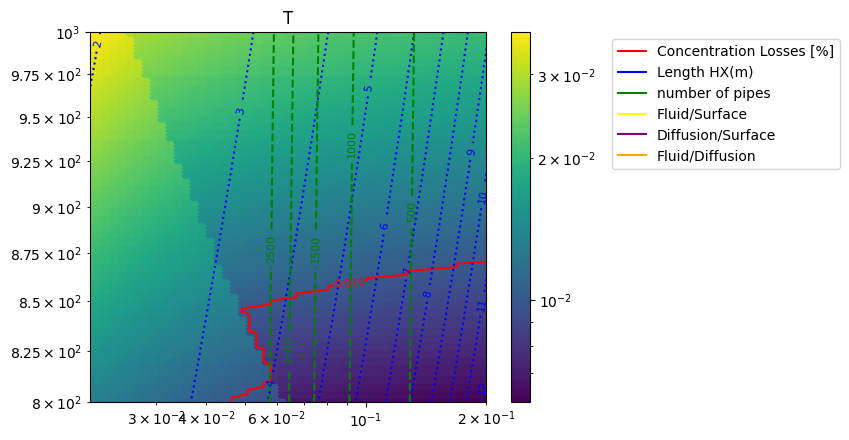

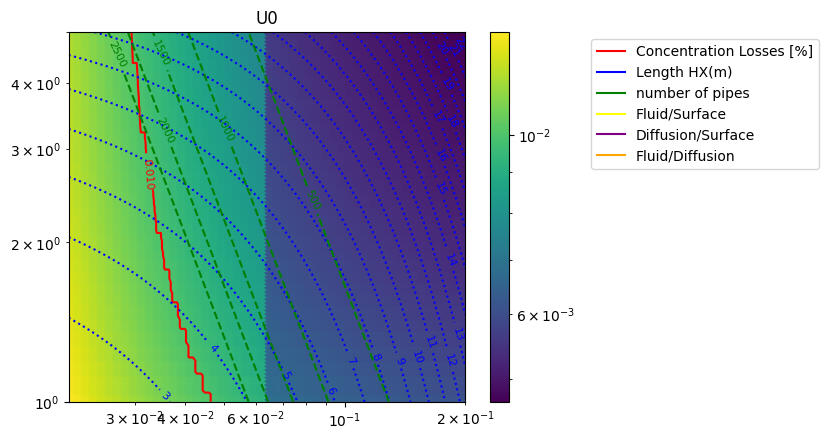

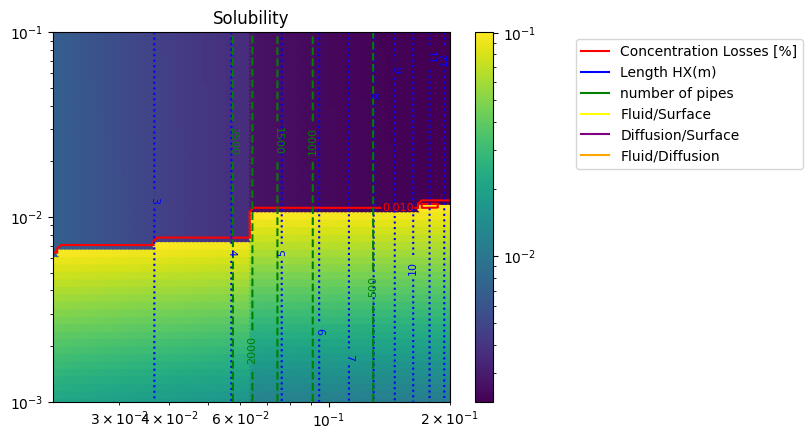

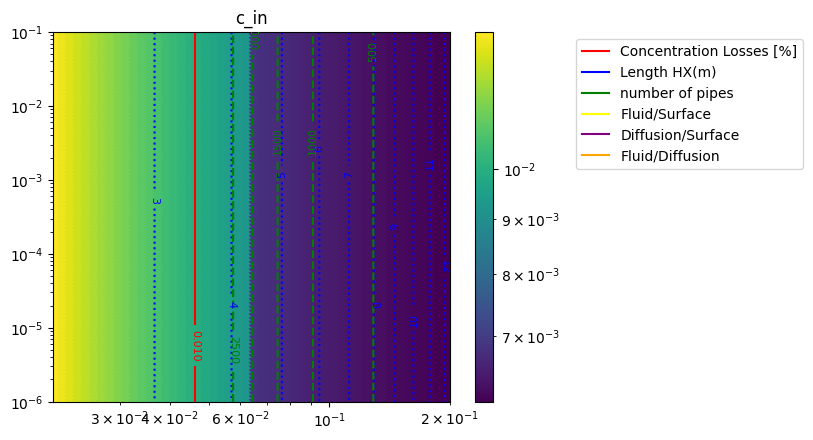

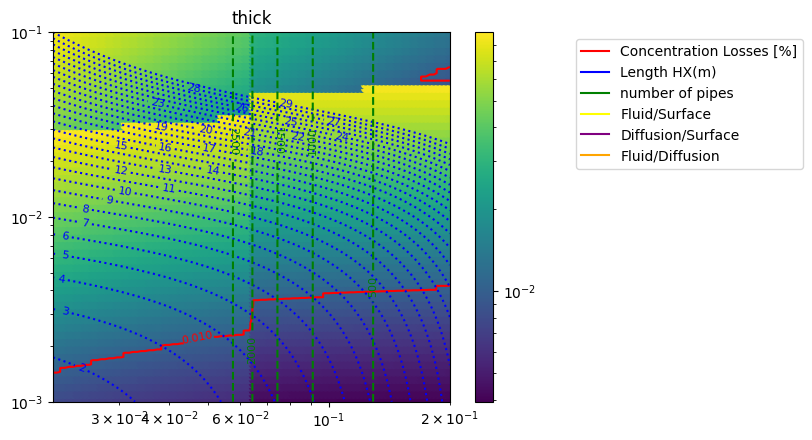

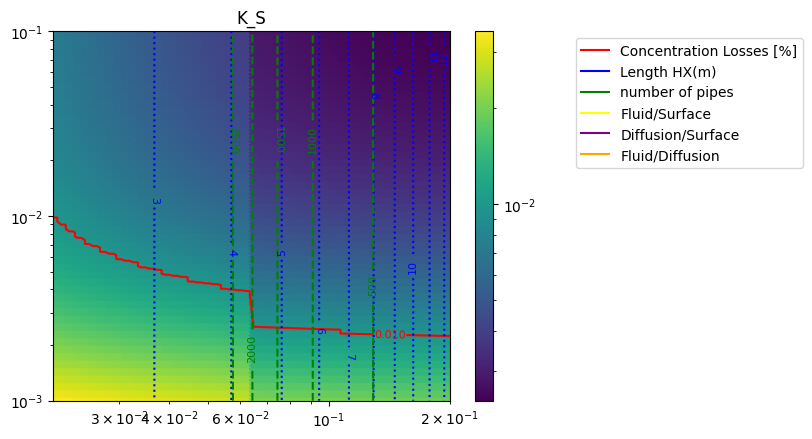

In [16]:
from turtle import color

from matplotlib.pyplot import sca


for j,vec in enumerate(v_vec):
        eff_v=np.array([])
        var_str=str_v_vec[j]
        T=800
        res_vec=np.array([])
        d_hyd_v_res=np.array([])
        var_vec=np.array([])
        L_vec=np.array([])
        n_pipes_v=np.array([])
        H_v=np.array([])
        W_v=np.array([])
        for var in vec:
                for i,d_hyd in enumerate(d_hyd_v):
                        if str_v_vec[j]=='T':
                                T=var
                        mat=materials.Flibe(T)
                        flibe=Fluid(T=T, Solubility=mat.Solubility, MS=False,D=mat.D, d_Hyd=d_hyd ,mu=mat.mu,rho=mat.rho,U0=1,k=mat.k,
                         cp=mat.cp)
                        BB=BreedingBlanket(Q=Q,TBR=1.08,T_out=T_hot_prim,T_in=T_cold_prim,fluid=flibe, c_in=0 )
                        BB.get_cout()
                        c0=BB.c_out
                        Steel = Membrane( T=T,
                                # D=7E-10,
                                D=1E-4,
                                thick=2.1E-3,
                                K_S=4.41E-3,
                                k_d=1E6,
                                k_r=1E6,k=21)
                        PAV = Component(c_in=c0,  fluid=flibe, membrane=Steel)
                        if fluid_v_bool[j]==True:
                                PAV.fluid.update_attribute(var_str,var)
                        elif solid_v_bool[j]==True:
                                PAV.membrane.update_attribute(var_str,var)
                        else:
                                PAV.update_attribute(var_str,var)
                        n_pipes=BB.m_coolant/(PAV.fluid.rho*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                        Q_HX=Q/n_pipes/N_HX
                        HX=Component(c_in=1, eff=0.08, fluid=flibe)
                        PAV.get_adimensionals()
                        d_h_sec=2.5E-2 # from HX forecasts
                        V_sec=m_in_sec/(rho_sec*d_h_sec**2*np.pi/4)/N_HX/n_pipes
                        Re_sec=corr.Re(rho=rho_sec,u=V_sec,mu=mu_sec,L=d_h_sec)
                        Pr_sec=corr.Pr(c_p=cp_sec,mu=mu_sec,k=k_sec)
                        h_coeff_sec=corr.get_h_from_Nu(corr.Nu_DittusBoelter(Re_sec, Pr_sec), k_sec,d_h_sec)
                        R_sec=1/h_coeff_sec
                        U = PAV.get_global_HX_coeff(0)
                        L= corr.get_length_HX(corr.get_deltaTML(T_hot_prim, T_cold_prim, T_cold_sec, T_hot_sec), PAV.fluid.d_Hyd, PAV.U, Q_HX)
                        PAV.get_efficiency(L,plotvar=False)
                        PAV.analytical_efficiency(L)
                        out_flux=(PAV.c_in*(1-PAV.eff)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                        eff_v=np.append(eff_v, abs(PAV.eff-PAV.eff_an)/PAV.eff_an)
                        d_hyd_v_res=np.append(d_hyd_v_res, d_hyd)
                        var_vec=np.append(var_vec, var)
                        # res_vec=np.append(res_vec, PAV.eff)
                        res_vec=np.append(res_vec, abs(PAV.eff-PAV.eff_an)/PAV.eff_an)
                        L_vec=np.append(L_vec, L)
                        n_pipes_v=np.append(n_pipes_v, n_pipes)
                        H_v=np.append(H_v, PAV.H)
                        W_v=np.append(W_v, PAV.W)
                eff_v_vec=np.append(eff_v_vec, eff_v)
        plt.figure(j)
        plt.title(str_v_vec[j])
        plt.yscale('log')
        plt.xscale('log')
        x = np.logspace(np.log10(min(d_hyd_v_res[:])), np.log10(max(d_hyd_v_res[:])), num=100)
        y = np.logspace(np.log10(min(var_vec[:])), np.log10(max(var_vec[:])), num=100)
        X, Y = np.meshgrid(x, y)
        Z = griddata((d_hyd_v_res, var_vec), (res_vec)*100, (X, Y), method='cubic')
        dZdX, dZdY = np.gradient(Z, x, y, edge_order=2)
        ZL=griddata((d_hyd_v_res, var_vec), L_vec, (X, Y), method='cubic')
        Zn_pipes=griddata((d_hyd_v_res, var_vec), n_pipes_v, (X, Y), method='cubic')
        ZH=griddata((d_hyd_v_res, var_vec), H_v, (X, Y), method='cubic')
        ZW=griddata((d_hyd_v_res, var_vec), W_v, (X, Y), method='cubic')
        Zratio=griddata((d_hyd_v_res, var_vec), H_v/W_v, (X, Y), method='cubic')
        contour1=plt.contour(X, Y, Z, levels=[1E-4,1E-3,1E-2,1E-1,1,10],norm=LogNorm(),colors=color_vector[0])
        contour2=plt.contour(X, Y, ZL, levels=range(1,30,1),colors=color_vector[1],linestyles='dotted')
        contour3=plt.contour(X, Y, Zn_pipes, levels=range(500,3000,500),colors=color_vector[2],linestyles='dashed')
        contour4=plt.contour(X, Y, ZH, levels=[0.1,0.2,10,20],colors=color_vector[3],linestyles='dotted')
        contour5=plt.contour(X, Y, ZW, levels=[0.1,0.2,10,20],colors=color_vector[4],linestyles='dotted')
        contour6=plt.contour(X, Y, Zratio, levels=[0.1,0.2,10,20],colors=color_vector[5],linestyles='dotted')
        scatter=plt.scatter(X,Y, c=Z ,norm=colors.LogNorm()) #,norm=colors.LogNorm() 
        plt.clabel(contour1, inline=True, fontsize=8)
        plt.clabel(contour2, inline=True, fontsize=8)
        plt.clabel(contour3, inline=True, fontsize=8)
        plt.clabel(contour4, inline=True, fontsize=8)
        plt.clabel(contour5, inline=True, fontsize=8)
        plt.clabel(contour6, inline=True, fontsize=8)
        if scatter:
                if np.nanmin(scatter.get_array()) < np.nanmax(scatter.get_array()):
                        plt.colorbar(scatter)  # Show color scale for scatter
                else:
                        print("Cannot create colorbar: data does not have a valid range of values.")
        line1 = mlines.Line2D([], [], color=color_vector[0], markersize=15, label='Concentration Losses [%]')
        line2 = mlines.Line2D([], [], color=color_vector[1], markersize=15, label='Length HX(m)')
        line3 = mlines.Line2D([], [], color=color_vector[2], markersize=15, label='number of pipes')
        line4 = mlines.Line2D([], [], color=color_vector[3], markersize=15, label='Fluid/Surface')
        line5 = mlines.Line2D([], [], color=color_vector[4], markersize=15, label='Diffusion/Surface')
        line6= mlines.Line2D([], [], color=color_vector[5], markersize=15, label='Fluid/Diffusion')
        plt.legend(handles=[ line1,line2, line3], loc='upper right')
        plt.legend(handles=[ line1,line2, line3,line4,line5,line6], bbox_to_anchor=(1.3, 1), loc='upper left')
        plt.show()

Jupyter notebook to test and run features of components in a FPP